In [61]:
import sys
sys.path.append(r"C:\cs229-journey\cs229-journey")

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import problem_sets.PS1.src.util as util

from problem_sets.PS1.src.linear_model import LinearModel

In [63]:
ds1_training_set_path = 'data/ds1_train.csv'
ds1_valid_set_path = 'data/ds1_valid.csv'
ds2_training_set_path = 'data/ds2_train.csv'
ds2_valid_set_path = 'data/ds2_valid.csv'

In [64]:
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=True)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=True)

We have a look to the data

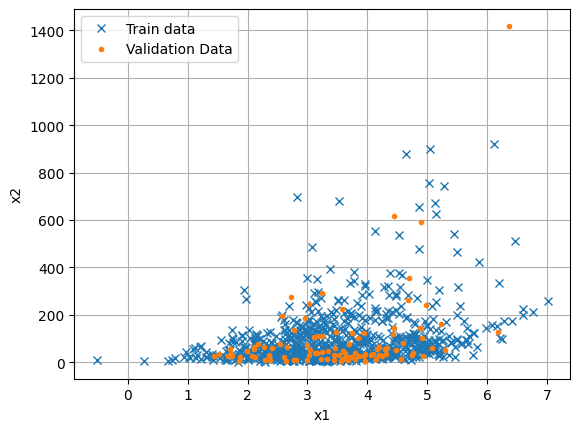

In [65]:
plt.plot(x_train[:, 1], x_train[:, 2], 'x')
plt.plot(x_valid[:, 1], x_valid[:, 2], '.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(["Train data", "Validation Data"])
plt.grid()
plt.show()

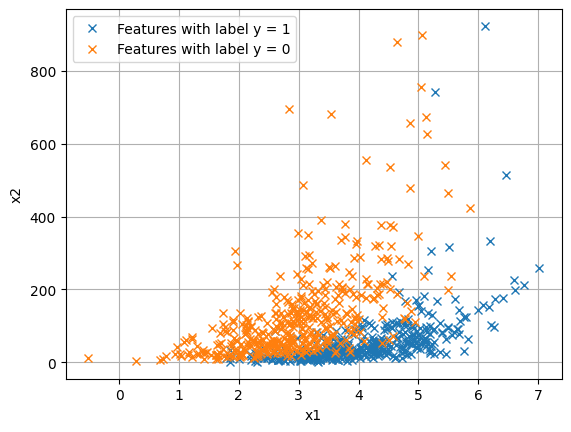

In [66]:
plt.plot(x_train[:, 1][y_train == 1], x_train[:, 2][y_train == 1], 'x')
plt.plot(x_train[:, 1][y_train == 0], x_train[:, 2][y_train == 0], 'x')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(["Features with label y = 1", "Features with label y = 0"])
plt.grid()
plt.show()

b) Follow the instructions in src/p01b logreg.py to train a
logistic regression classifier using Newton’s Method. Starting with θ = 0, run Newton’s
Method until the updates to θ are small: Specifically, train until the first iteration k such
that $‖θ_k −θ_{k−1}‖_1 <\epsilon$, where $ \epsilon = 1 ×10^{-5}$. Make sure to write your model’s predictions to
the file specified in the code

In [67]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """
        def sigmoid(theta):
            return 1/(1+np.exp(-np.dot(x, theta)))
        
        def gradient_loss(theta):
            return -np.dot(x.T, (y - sigmoid(theta)))/m
        
        def hessian(theta):
            h_theta_x = np.reshape(sigmoid(theta), (-1, 1))
            return 1 / m * np.dot(x.T, h_theta_x * (1 - h_theta_x) * x)
        
        def newton_step(H, gradient, theta):
            return theta - np.dot(np.linalg.inv(H), gradient)
        
        m, n = x.shape

        self.theta = np.zeros(n)
        while True:
            theta = np.copy(self.theta)
            gradient = gradient_loss(theta)
            H = hessian(theta)
            self.theta = newton_step(H, gradient, theta)
            if np.linalg.norm(self.theta - theta) < self.eps:
                break


    def predict(self, x):
        """Make a prediction given new inputs x.

        :param x: Inputs of shape (m, n).
        :return:  Outputs of shape (m,).
        """
        probs = 1/(1+np.exp(-np.dot(x, self.theta)))
        return probs

In [68]:
model = LogisticRegression(eps=1e-5)
model.fit(x_train, y_train)

Optimal theta is:  [-6.26018491  2.47707251 -0.0299125 ]
The accuracy on training set is: 88.25%


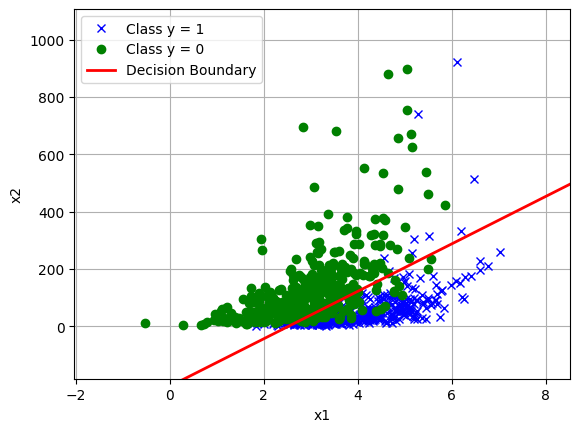

In [69]:
util.plot(x_train, y_train, theta=model.theta, correction=1)
plt.legend(["Class y = 1", "Class y = 0", "Decision Boundary"])
plt.grid()
print("Optimal theta is: ", model.theta)
print(f"The accuracy on training set is: {np.mean((model.predict(x_train)>0.5) == y_train):.2%}")

The accuracy on validation set is: 90.00%


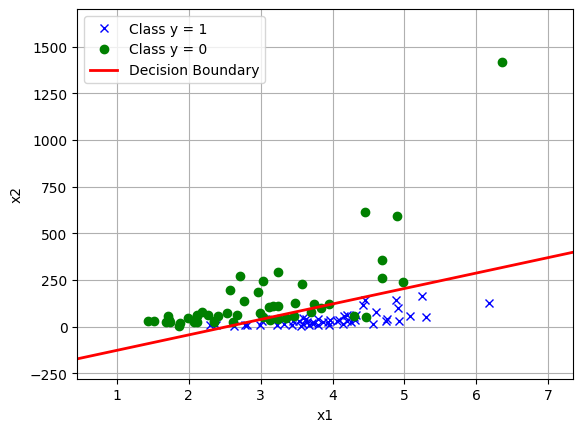

In [70]:
util.plot(x_valid, y_valid, model.theta)
plt.legend(["Class y = 1", "Class y = 0", "Decision Boundary"])
plt.grid()
print(f"The accuracy on validation set is: {np.mean((model.predict(x_valid) > 0.5) == y_valid):.2%}")

e)  In src/p01e_gda.py, fill in the code to calculate $\phi$, $\mu_0$, $\mu_1$ and $\Sigma$, use these parameters to derive $\theta$, and use the resulting GDA model to make
 predictions on the validation set.

In [71]:
# We load the data without x_0 = 1
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=False)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=False)

In [72]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        m, n = x.shape
        phi = np.sum(y) / m
        mu_0 = np.sum(x[y == 0], axis= 0)/np.sum(y == 0)
        mu_1 = np.sum(x[y == 1], axis = 0)/np.sum(y)
        y_reshaped = y.reshape(m, 1)
        mu_x = y_reshaped * mu_1 + (1 - y_reshaped) * mu_0
        x_centered = x - mu_x
        sigma = np.dot(x_centered.T, x_centered)/m
        inv_sigma = np.linalg.inv(sigma)
        #From exercise c)
        self.theta = np.dot(inv_sigma, (mu_1 - mu_0))
        self.theta_0 = -1/2 * (mu_1 @ inv_sigma @ mu_1.T - mu_0 @ inv_sigma @ mu_0.T) - np.log((1-phi)/phi)

        



    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        probs = 1/(1+np.exp(-(x@self.theta + self.theta_0)))
        return probs
        # *** END CODE HERE


In [73]:
model_gda = GDA()
model_gda.fit(x = x_train, y = y_train)

Optimal theta is:  [-6.26018491  2.47707251 -0.0299125 ]
The accuracy on training set is: 86.62%


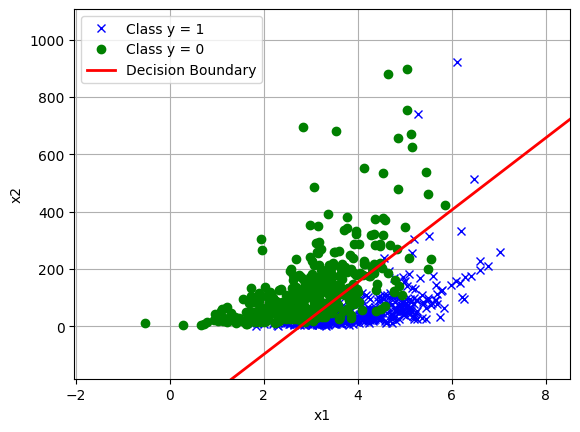

In [74]:
util.plot(x_train, y_train, theta=np.insert(model_gda.theta, 0, model_gda.theta_0))
plt.legend(["Class y = 1", "Class y = 0", "Decision Boundary"])
plt.grid()
print("Optimal theta is: ", model.theta)
print(f"The accuracy on training set is: {np.mean((model_gda.predict(x_train)>0.5) == y_train):.2%}")

Optimal theta is:  [-6.26018491  2.47707251 -0.0299125 ]
The accuracy on validation set is: 83.00%


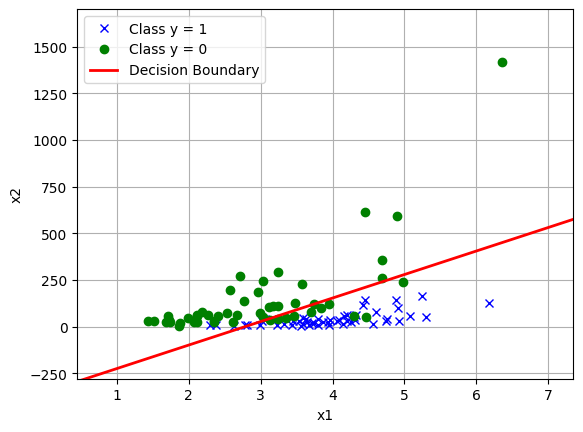

In [75]:
util.plot(x_valid, y_valid, theta=np.insert(model_gda.theta, 0, model_gda.theta_0))
plt.legend(["Class y = 1", "Class y = 0", "Decision Boundary"])
plt.grid()
print("Optimal theta is: ", model.theta)
print(f"The accuracy on validation set is: {np.mean((model_gda.predict(x_valid) > 0.5) == y_valid):.2%}")

f) For Dataset 1, create a plot of the training data with $x_1$ on the horizontal axis, and
 $x_2$ on the vertical axis. To visualize the two classes, use a di erent symbol for examples $x^{(i)}$
 with $y^{(i)} = 0$ than for those with $y^{(i)} = 1$. On the same gure, plot the decision boundary
 found by logistic regression in part (b). Make an identical plot with the decision boundary
 found by GDA in part (e).

In [76]:
def plot(x, y, theta_1, theta_2, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters and GDA parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta_1: Vector of parameters for logistic regression model.
        theta_2: Vector of parameters for GDA model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2, label = "Class y = 1")
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2, label = "Class y = 0")

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta_1[0] / theta_1[2] * correction + theta_1[1] / theta_1[2] * x1)
    x3 = -(theta_2[0] / theta_2[2] * correction + theta_2[1] / theta_2[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2, label = "Logistic Regression Decision Boundary")
    plt.plot(x1, x3, c='black', linewidth=2, label = "GDA Decision Boundary")
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(save_path)

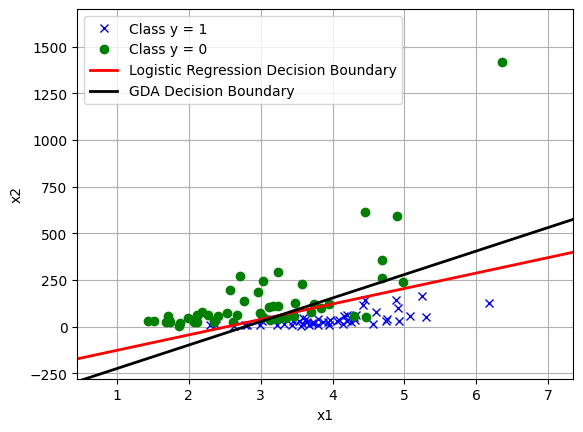

In [77]:
plot(x_valid, y_valid, theta_1=model.theta, theta_2=np.insert(model_gda.theta, 0, model_gda.theta_0))

We see that the decision boundary of the GDA Model is worts that the decision boundary of the LR model

(g) [5 points] Repeat the steps in part (f) for Dataset 2. On which dataset does GDA seem to
perform worse than logistic regression? Why might this be the case?

In [78]:
x_train, y_train = util.load_dataset(ds2_training_set_path, add_intercept=False)
x_valid, y_valid = util.load_dataset(ds2_valid_set_path, add_intercept=False)

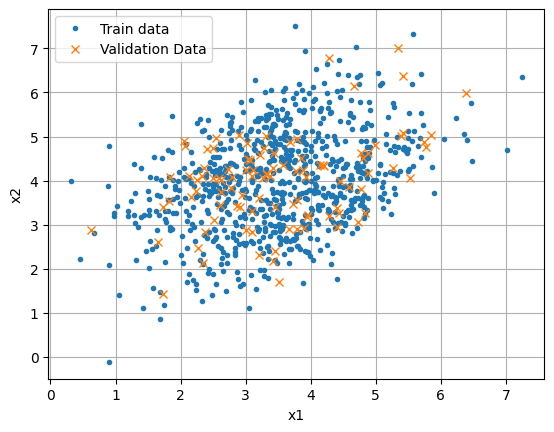

In [79]:
plt.plot(x_train[:, 0], x_train[:, 1], '.')
plt.plot(x_valid[:, 0], x_valid[:, 1], 'x')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(["Train data", "Validation Data"])
plt.grid()
plt.show()

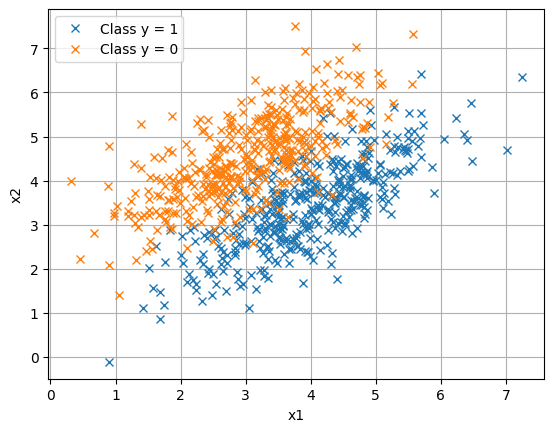

In [80]:
plt.plot(x_train[:, 0][y_train == 1], x_train[:, 1][y_train == 1], 'x')
plt.plot(x_train[:, 0][y_train == 0], x_train[:, 1][y_train == 0], 'x')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(["Class y = 1", "Class y = 0"])
plt.grid()
plt.show()

In [81]:
#we train LogisticRegression
x_train_intercep = util.add_intercept(x_train)
x_valid_intercep = util.add_intercept(x_valid)
model.fit(x_train_intercep, y_train)
model.predict(x_valid_intercep)

error_train = np.mean((model.predict(x_train_intercep)>0.5) == y_train)
test_error = np.mean((model.predict(x_valid_intercep)>0.5) == y_valid)
print(f"Training accuracy: {error_train:.2%}")
print(f"Training accuracy: {test_error:.2%}")

Training accuracy: 91.50%
Training accuracy: 91.00%


In [82]:
#we train GDA
x_train, y_train = util.load_dataset(ds2_training_set_path, add_intercept=False)
x_valid, y_valid = util.load_dataset(ds2_valid_set_path, add_intercept=False)
model_gda.fit(x_train, y_train)
model_gda.predict(x_valid)

error_train = np.mean((model_gda.predict(x_train)>0.5) == y_train)
test_error = np.mean((model_gda.predict(x_valid)>0.5) == y_valid)
print(f"Training accuracy: {error_train:.2%}")
print(f"Training accuracy: {test_error:.2%}")

Training accuracy: 91.38%
Training accuracy: 91.00%


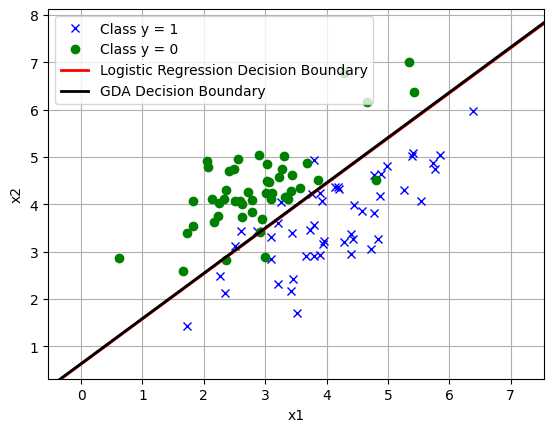

In [83]:
plot(x_valid, y_valid, theta_1=model.theta, theta_2=np.insert(model_gda.theta, 0, model_gda.theta_0))

In this case the GDA performs as good as the LR. This is because in this case the data follows a Gaussian distribution, which was not the case with the dataset 1 as we can see in the plot of x2 vs x1

h) For the dataset where GDA performed worse in parts (f) and (g),
 can you nd a transformation of the $x^{(i)}$ s such that GDA performs signicantly better?
 What is this transformation?


Looking the second plot of the b) exercise we see that $x_2 > 0$ and also that have significant high values we can apply a log transformation

In [84]:
x_train, y_train = util.load_dataset(ds1_training_set_path, add_intercept=False)
x_valid, y_valid = util.load_dataset(ds1_valid_set_path, add_intercept=False)

In [85]:
x_train_transformed = np.stack((x_train[:, 0], np.log(x_train[:,1])),axis=1)
x_valid_transformed = np.stack((x_valid[:, 0], np.log(x_valid[:,1])),axis=1)

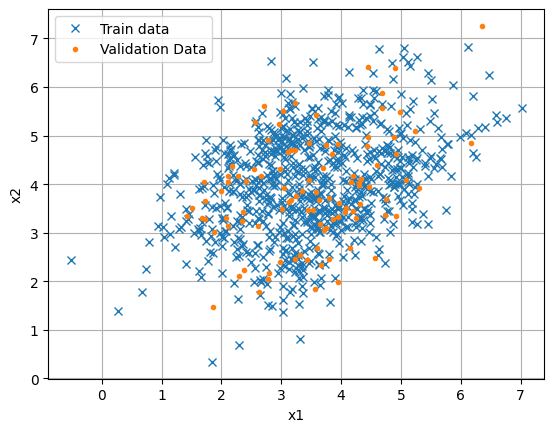

In [86]:
plt.plot(x_train_transformed[:, 0], x_train_transformed[:, 1], 'x')
plt.plot(x_valid_transformed[:, 0], x_valid_transformed[:, 1], '.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(["Train data", "Validation Data"])
plt.grid()
plt.show()

In [87]:
#we train LR
x_train_transformed_intercep = util.add_intercept(x_train_transformed)
x_valid_transformed_intercep = util.add_intercept(x_valid_transformed)
model.fit(x_train_transformed_intercep, y_train)

error_train = np.mean((model.predict(x_train_transformed_intercep)>0.5) == y_train)
test_error = np.mean((model.predict(x_valid_transformed_intercep)>0.5) == y_valid)
print(f"Training accuracy on logistic regression: {error_train:.2%}")
print(f"Validation accuracy on logistic regression: {test_error:.2%}")

Training accuracy on logistic regression: 91.00%
Validation accuracy on logistic regression: 95.00%


In [88]:
#we train GDA
model_gda.fit(x_train_transformed, y_train)

error_train = np.mean((model_gda.predict(x_train_transformed)>0.5) == y_train)
test_error = np.mean((model_gda.predict(x_valid_transformed)>0.5) == y_valid)
print(f"Training accuracy on GDA: {error_train:.2%}")
print(f"Validation accuracy on GDA: {test_error:.2%}")

Training accuracy on GDA: 91.25%
Validation accuracy on GDA: 95.00%


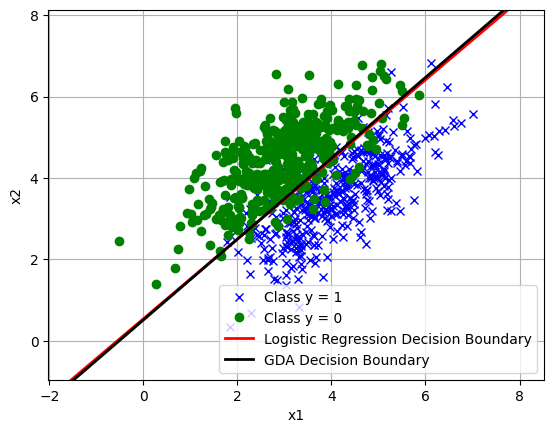

In [89]:
plot(x_train_transformed, y_train, theta_1= model.theta, theta_2=np.insert(model_gda.theta, 0, model_gda.theta_0))

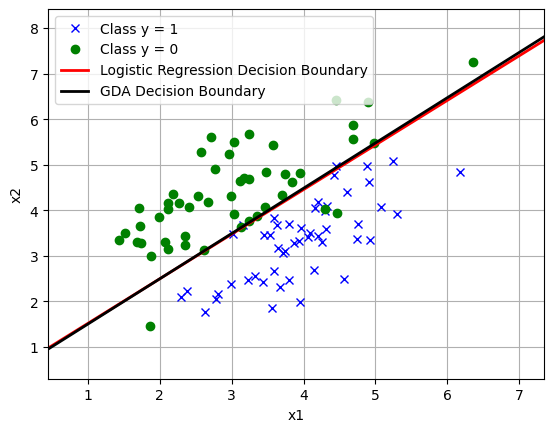

In [90]:
plot(x_valid_transformed, y_valid, theta_1= model.theta, theta_2=np.insert(model_gda.theta, 0, model_gda.theta_0))

In this case we see that both algorithms behave the same